<a href="https://colab.research.google.com/github/saintblue97/DeepNN_Optiver/blob/main/brett_10_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
# # !mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
# # !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
# #!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
# # !chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
# !kaggle config set -n competition -v optiver-trading-at-the-close        # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
# !kaggle competitions download >> log                          # download competition dataset as a zip file
# !unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
# # !kaggle competitions leaderboard --show                       # print public leaderboard

In [1]:
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from itertools import combinations

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor, plot_importance


np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 50, 'display.precision', 5, 'display.max_rows', 50)

In [2]:
# def is_google_colab():
#     """Check if the environment is Google Colab.

#     Returns:
#         bool: True if in Google Colab, False otherwise.
#     """
#     try:
#         import google.colab
#         return True
#     except ImportError:
#       return False

# if is_google_colab():
#   file_path = ''
# else:
#   file_path = '/kaggle/input/optiver-trading-at-the-close/'

In [3]:
file_path = ''

sample_submission_path = file_path + 'example_test_files/sample_submission.csv'

sample_submission = pd.read_csv(sample_submission_path); sample_submission

,time_id,row_id,target
0,26290,478_0_0,0
1,26290,478_0_1,0
2,26290,478_0_2,0
3,26290,478_0_3,0
4,26290,478_0_4,0
...,...,...,...
32995,26454,480_540_195,0
32996,26454,480_540_196,0
32997,26454,480_540_197,0
32998,26454,480_540_198,0


# Load Data

In [4]:
train_data_path = file_path + 'train.csv'
df = pd.read_csv(train_data_path);
df = df.dropna(subset=['target']).reset_index(drop=True); df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3.18060e+06,1,0.99981,1.33803e+07,NaN,NaN,0.99981,60651.50,1.00003,8493.03,1.00000,-3.02970,0,0_0_0
1,1,0,0,1.66604e+05,-1,0.99990,1.64221e+06,NaN,NaN,0.99990,3233.04,1.00066,20605.09,1.00000,-5.51999,0,0_0_1
2,2,0,0,3.02880e+05,-1,0.99956,1.81937e+06,NaN,NaN,0.99940,37956.00,1.00030,18995.00,1.00000,-8.38995,0,0_0_2
3,3,0,0,1.19177e+07,-1,1.00017,1.83897e+07,NaN,NaN,1.00000,2324.90,1.00021,479032.40,1.00000,-4.01020,0,0_0_3
4,4,0,0,4.47550e+05,-1,0.99953,1.78606e+07,NaN,NaN,0.99939,16485.54,1.00002,434.10,1.00000,-7.34985,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237887,195,480,540,2.44072e+06,-1,1.00032,2.82804e+07,0.99973,0.99973,1.00032,32257.04,1.00043,319862.40,1.00033,2.31028,26454,480_540_195
5237888,196,480,540,3.49510e+05,-1,1.00064,9.18770e+06,1.00013,1.00039,1.00064,205108.40,1.00090,93393.07,1.00082,-8.22008,26454,480_540_196
5237889,197,480,540,0.00000e+00,0,0.99579,1.27254e+07,0.99579,0.99579,0.99579,16790.66,0.99588,180038.32,0.99580,1.16944,26454,480_540_197
5237890,198,480,540,1.00090e+06,1,0.99921,9.47733e+07,0.99921,0.99921,0.99897,125631.72,0.99921,669893.00,0.99901,-1.54018,26454,480_540_198


In [5]:
test_data_path = file_path + 'example_test_files/test.csv'
df_test  = pd.read_csv(test_data_path); df_test

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,currently_scored
0,0,478,0,3753451.43,-1,0.99987,1.15490e+07,NaN,NaN,0.99987,22940.00,1.00005,9177.60,1.00000,26290,478_0_0,False
1,1,478,0,985977.11,-1,1.00025,3.85003e+06,NaN,NaN,0.99994,1967.90,1.00060,19692.00,1.00000,26290,478_0_1,False
2,2,478,0,599128.74,1,1.00058,4.35920e+06,NaN,NaN,0.99992,4488.22,1.00064,34955.12,1.00000,26290,478_0_2,False
3,3,478,0,2872317.54,-1,0.99980,2.71296e+07,NaN,NaN,0.99970,16082.04,1.00019,10314.00,1.00000,26290,478_0_3,False
4,4,478,0,740059.14,-1,0.99989,8.88089e+06,NaN,NaN,0.99972,19012.35,1.00011,7245.60,1.00000,26290,478_0_4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,195,480,540,2440722.89,-1,1.00032,2.82804e+07,0.99973,0.99973,1.00032,32257.04,1.00043,319862.40,1.00033,26454,480_540_195,False
32996,196,480,540,349510.47,-1,1.00064,9.18770e+06,1.00013,1.00039,1.00064,205108.40,1.00090,93393.07,1.00082,26454,480_540_196,False
32997,197,480,540,0.00,0,0.99579,1.27254e+07,0.99579,0.99579,0.99579,16790.66,0.99588,180038.32,0.99580,26454,480_540_197,False
32998,198,480,540,1000898.84,1,0.99921,9.47733e+07,0.99921,0.99921,0.99897,125631.72,0.99921,669893.00,0.99901,26454,480_540_198,False


In [6]:
# Split dataframe into X and y
X, y = df.drop('target', axis=1), df.target

### Create train/validation/test splits

In [7]:
def create_train_test_split(X, y, test_size=0.2):    
    ### Need to create train/test split for each stock_id
    size = int(len(X)*test_size)
    train_idxs, test_idxs = X.index[:-size], X.index[-size:]

    X_train, X_test = X.iloc[train_idxs], X.iloc[test_idxs]
    y_train, y_test = y[train_idxs], y[test_idxs]

    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_valid, y_train, y_valid = create_train_test_split(X, y)

In [9]:
print('Shape of training data    =', X_train.shape)
print('Shape of validation data  =', X_valid.shape)
print('Shape of testing data     =', df_test.shape)

Shape of training data    = (4190314, 16)
Shape of validation data  = (1047578, 16)
Shape of testing data     = (33000, 17)


In [10]:
X_train.drop(columns=["time_id"]).describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap
count,4.19031e+06,4.19031e+06,4.19031e+06,4.19024e+06,4.19031e+06,4.19024e+06,4.19024e+06,1.87232e+06,1.90322e+06,4.19024e+06,4.19031e+06,4.19024e+06,4.19031e+06,4.19024e+06
mean,9.92348e+01,1.93667e+02,2.69869e+02,5.62001e+06,8.14020e-04,1.00000e+00,4.46016e+07,1.00237e+00,9.99809e-01,9.99731e-01,5.03354e+04,1.00027e+00,5.18964e+04,9.99998e-01
std,5.79058e+01,1.11153e+02,1.58705e+02,2.02596e+07,8.78269e-01,2.59094e-03,1.37159e+08,8.07120e-01,1.18807e-02,2.55717e-03,1.10751e+05,2.57161e-03,1.30273e+05,2.56014e-03
min,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,-1.00000e+00,9.35285e-01,1.87332e+04,7.70000e-05,8.62755e-01,9.34915e-01,5.40000e+00,9.39827e-01,6.95000e+00,9.38008e-01
25%,4.90000e+01,9.80000e+01,1.30000e+02,5.26157e+04,-1.00000e+00,9.98719e-01,5.23738e+06,9.96445e-01,9.97148e-01,9.98481e-01,7.13500e+03,9.98985e-01,7.49866e+03,9.98734e-01
50%,9.90000e+01,1.94000e+02,2.70000e+02,1.05224e+06,0.00000e+00,9.99965e-01,1.27771e+07,9.99903e-01,9.99905e-01,9.99721e-01,2.12667e+04,1.00021e+00,2.20470e+04,9.99996e-01
75%,1.49000e+02,2.90000e+02,4.10000e+02,4.06459e+06,1.00000e+00,1.00122e+00,3.24233e+07,1.00337e+00,1.00265e+00,1.00095e+00,5.39571e+04,1.00146e+00,5.55264e+04,1.00120e+00
max,1.99000e+02,3.85000e+02,5.40000e+02,2.98203e+09,1.00000e+00,1.05354e+00,7.71368e+09,4.37953e+02,1.14810e+00,1.05063e+00,3.02878e+07,1.05800e+00,5.44050e+07,1.05322e+00


### EDA

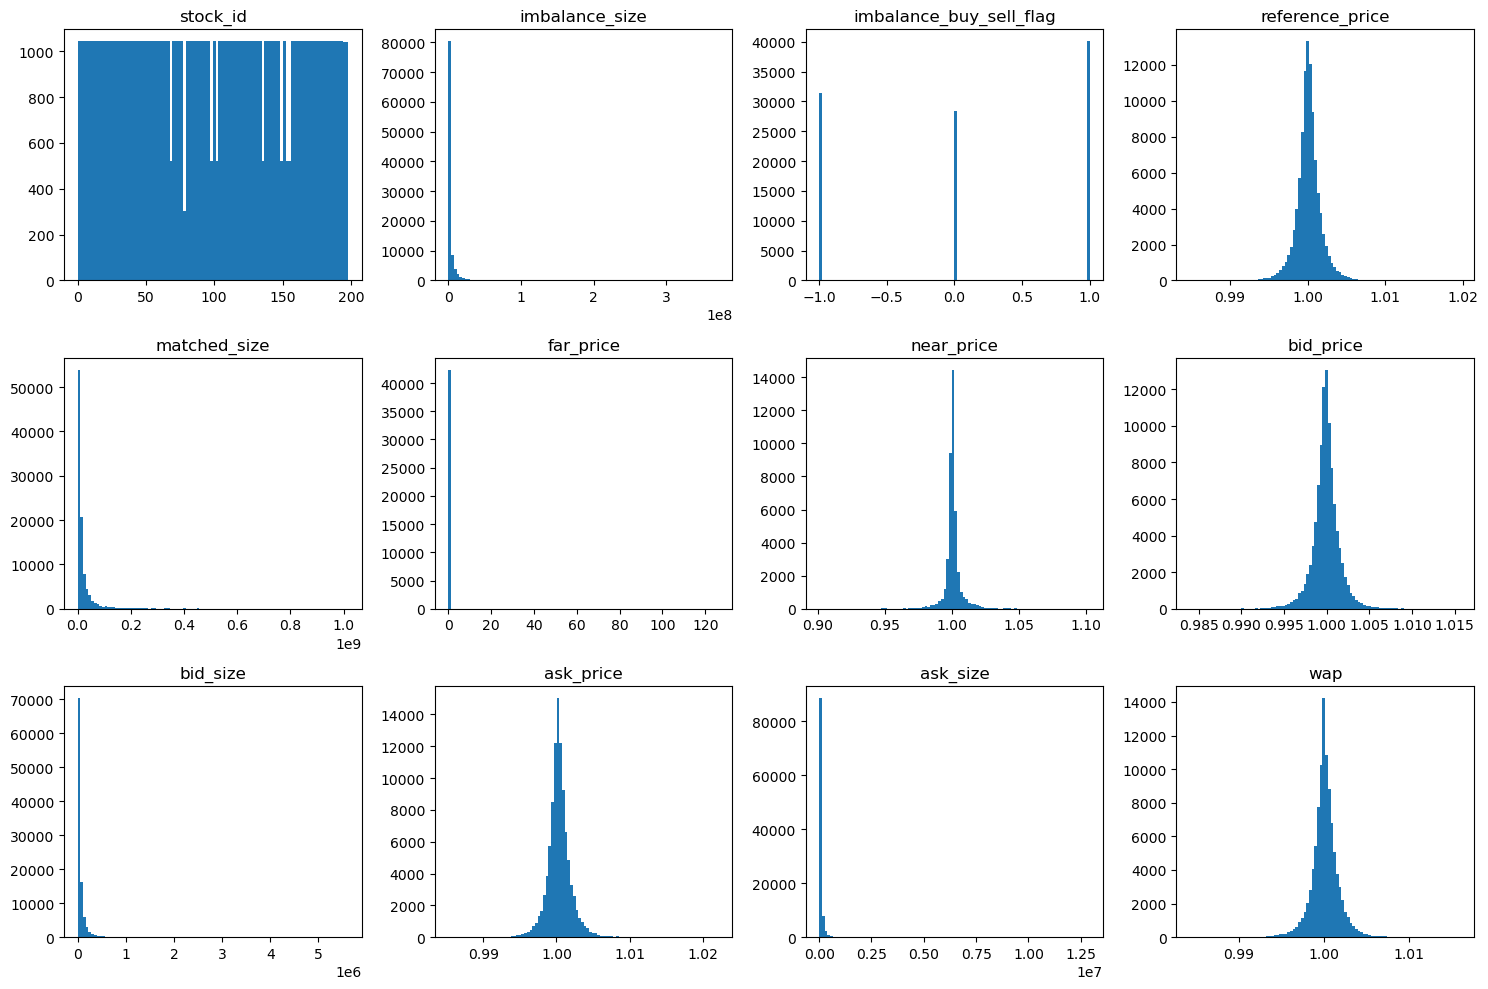

In [11]:
# Look at distributions of features
n_samples = 100000
feats = df.loc[:, ~df.columns.isin(["date_id", "seconds_in_bucket", "time_id", "row_id", "target"])].columns
plt.figure(1, figsize=(15, 10))
for i, feat in enumerate(feats):
    plt.subplot(3, 4, i+1)
    plt.hist(df.loc[:n_samples, feat], bins=100)
    plt.title(feat)

plt.tight_layout()

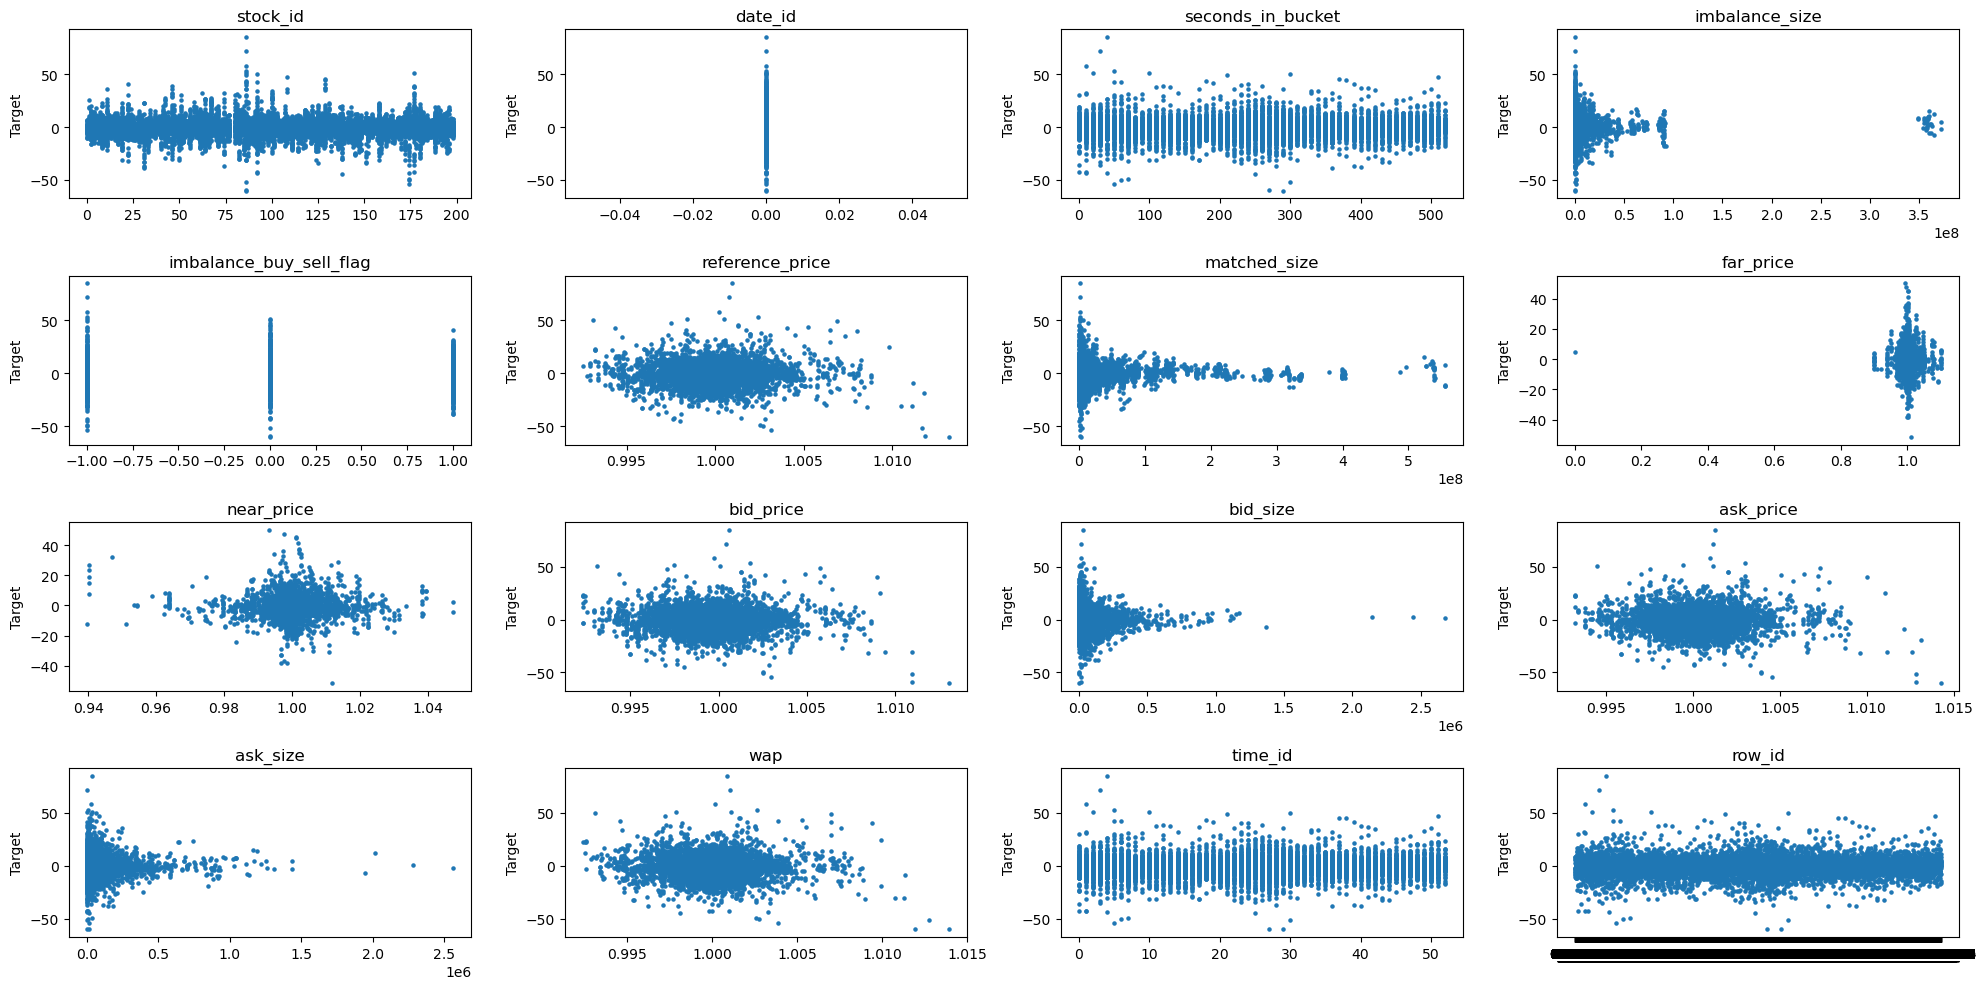

In [26]:
plt.figure(1, figsize=(20, 10))
for i, col in enumerate(X.columns):
    plt.subplot(4, 4, i+1)
    plt.scatter(X.loc[:10000-1, col].values, y[:10000].values, s=5)
    plt.title(col)
    plt.ylabel('Target');

plt.tight_layout()

In [13]:
skewed_feats = ['bid_size', 'ask_size', 'far_price', 'imbalance_size', 'matched_size']

In [14]:
# Check for null values
df.isna().any()

stock_id                   False
date_id                    False
seconds_in_bucket          False
imbalance_size              True
imbalance_buy_sell_flag    False
reference_price             True
matched_size                True
far_price                   True
near_price                  True
bid_price                   True
bid_size                   False
ask_price                   True
ask_size                   False
wap                         True
target                     False
time_id                    False
row_id                     False
dtype: bool

In [15]:
def get_stock_idxs(X, id):
    return X.query(f"stock_id == {id}").index

In [16]:
np.random.seed(42)
stock_ids = np.random.choice(X.stock_id.unique(), size=9, replace=False)

stocks = {
    id: {
        "train": get_stock_idxs(X_train, id),
        "valid": get_stock_idxs(X_valid, id)
    } for id in stock_ids
}

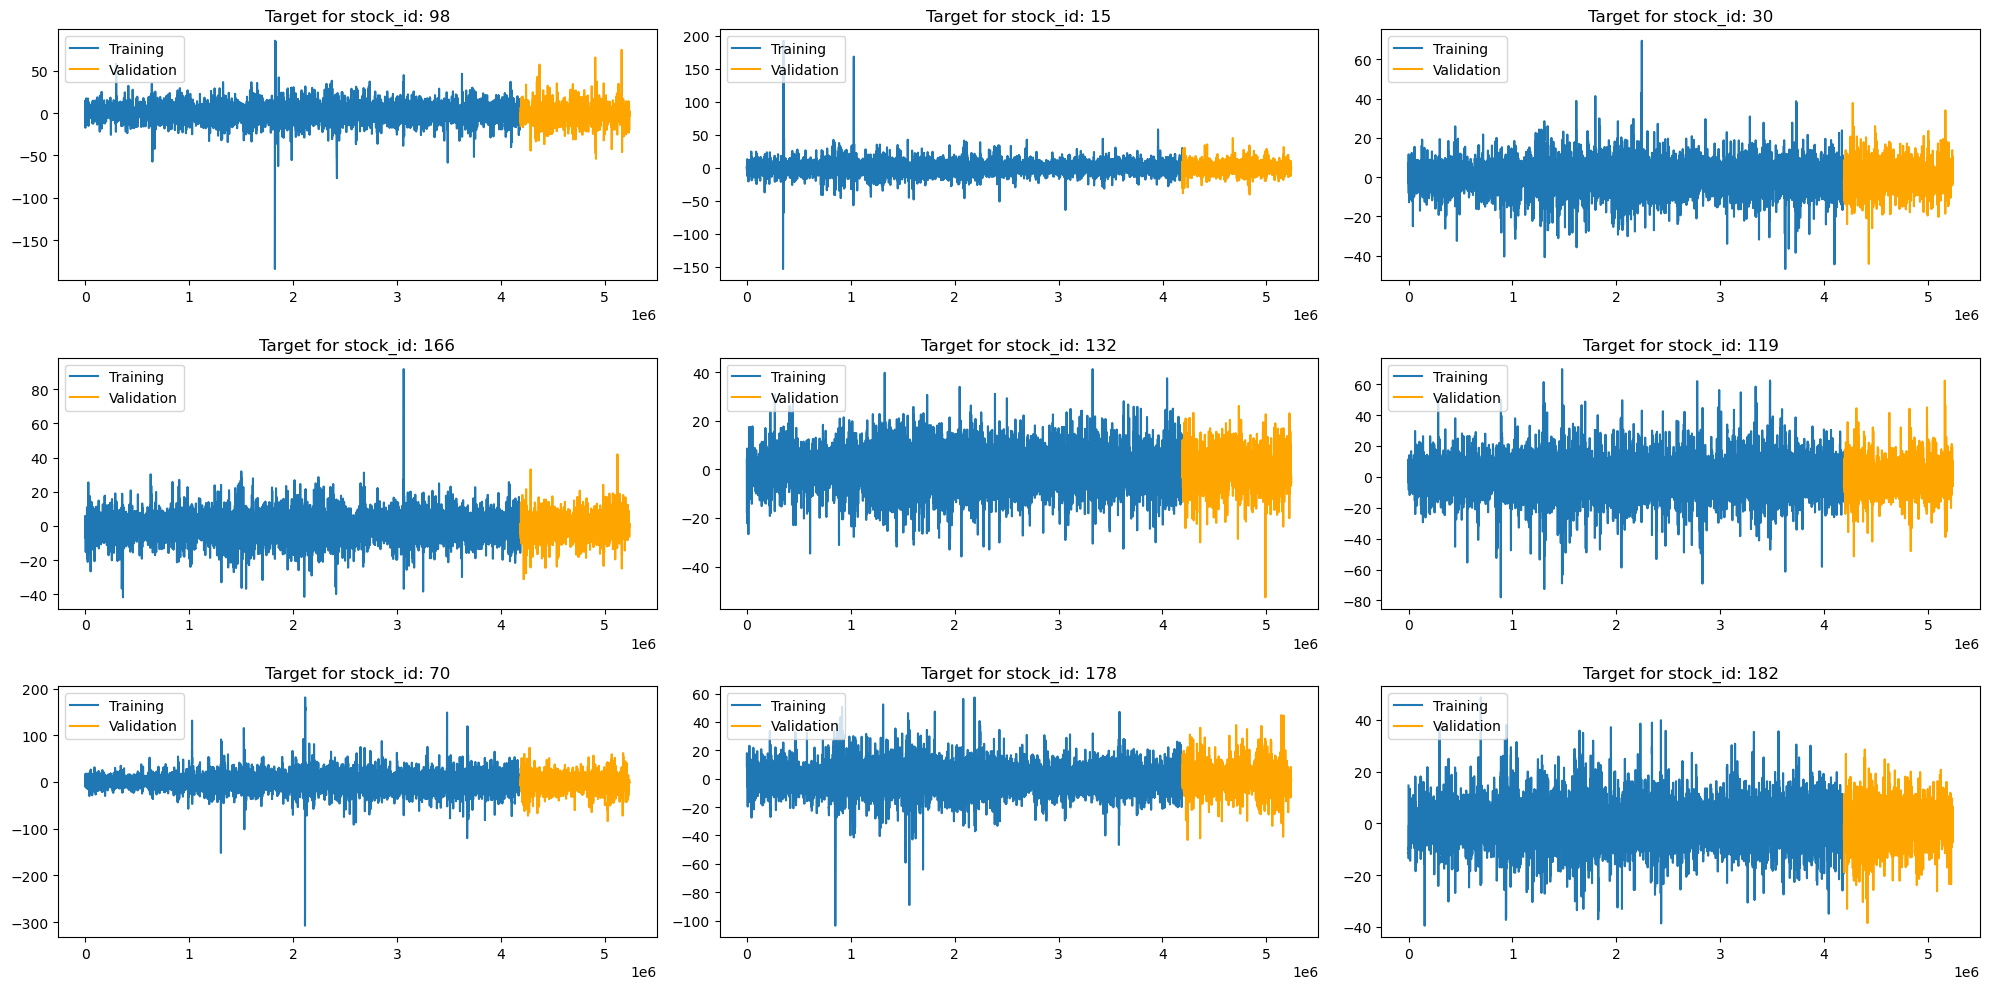

In [17]:
def plot_stock_target(
    y_train,
    y_valid,
    stock_id,
    idxs,
    ax,
):
    train_idxs, valid_idxs = idxs['train'], idxs['valid']
    ax.plot(y_train[train_idxs], label="Training")
    ax.plot(y_valid[valid_idxs], label="Validation", color='orange')
    ax.set_title(f"Target for stock_id: {stock_id}")
    ax.legend(loc='upper left');

fig = plt.figure(1, figsize=(20, 10))
for i, stock_id in enumerate(stock_ids):
    ax = plt.subplot(3, 3, i+1)
    idxs = stocks[stock_id]
    plot_stock_target(
        y_train,
        y_valid,
        stock_id,
        idxs,
        ax
    )

plt.tight_layout()

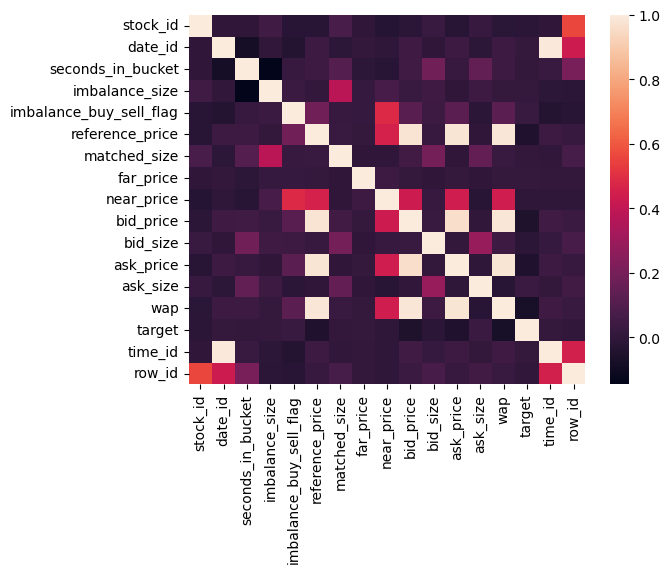

In [18]:
# Plot correlation matrix
sns.heatmap(df.iloc[:n_samples].corr());

# Preprocessing

In [19]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Only drop columns that exist in X
        columns_to_drop = [col for col in self.columns_to_drop if col in X.columns]
        return X.drop(columns_to_drop, axis=1)

class DataFrameSimpleImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean', fill_value=None):
        self.strategy_ = strategy
        self.fill_value_ = fill_value
        self.fill_value = fill_value
        self.strategy = strategy

    def fit(self, X, y=None):
        if self.strategy_ == 'mean':
            self.fill_values_ = X.mean()
        elif self.strategy_ == 'median':
            self.fill_values_ = X.median()
        elif self.strategy_ == 'constant':
            if self.fill_value_ is None:
                raise ValueError("fill_value must be provided for strategy='constant'")
            self.fill_values_ = pd.Series(self.fill_value_, index=X.columns)
        else:
            raise ValueError(f"Unknown strategy type: {self.strategy_}")

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill_values_)

class MovingAverageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size, columns):
        self.window_size = window_size  # The size of the window for moving average
        self.columns = columns          # The columns on which to apply moving average

    def fit(self, X, y=None):
        return self  # No fitting process, so just return self

    def calculate_moving_average(self, series):
        return series.rolling(window=self.window_size).mean()

    def transform(self, X):
        X_new = X.copy()

        for col in self.columns:
            X_new[f'{col}_sma_{self.window_size}'] = X_new.groupby('stock_id')[col].transform(self.calculate_moving_average)

            X_new[f'{col}_sma_{self.window_size}'].fillna(X_new[col], inplace=True)


        return X_new

In [20]:
# generate imbalance features


def imbalance_features(df):
    # Create a copy of the DataFrame to avoid modifying the original data
    df_copy = df.copy()

    # Define price and size columns
    prices = ["reference_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size"]

    # Calculate the total volume for each entry
    # Volume is the sum of ask and bid sizes
    df_copy["volume"] = df_copy["ask_size"] + df_copy["bid_size"]

    # Calculate the mid price for each entry
    # Mid price is the average of ask and bid prices
    df_copy["mid_price"] = (df_copy["ask_price"] + df_copy["bid_price"]) / 2

    # Calculate liquidity imbalance
    # Liquidity imbalance is the difference between bid and ask sizes divided by their sum
    df_copy["liquidity_imbalance"] = (df_copy["bid_size"] - df_copy["ask_size"]) / (df_copy["bid_size"] + df_copy["ask_size"])

    # Calculate price imbalances for all combinations of price types
    for price_pair in combinations(prices, 2):
        col_name = f"{price_pair[0]}_{price_pair[1]}_imb"
        df_copy[col_name] = (df_copy[price_pair[0]] - df_copy[price_pair[1]]) / (df_copy[price_pair[0]] + df_copy[price_pair[1]])

    # Calculate the price spread
    # Price spread is the difference between ask and bid prices
    df_copy["price_spread"] = df_copy["ask_price"] - df_copy["bid_price"]

    # Calculate spread depth ratio
    # Spread depth ratio is the price spread divided by the sum of bid and ask sizes
    df_copy["spread_depth_ratio"] = df_copy["price_spread"] / (df_copy["bid_size"] + df_copy["ask_size"])

    # Calculate aggregate statistics (mean and standard deviation) for prices and sizes
    df_copy["all_prices_mean"] = df_copy[prices].mean(axis=1)
    df_copy["all_prices_std"] = df_copy[prices].std(axis=1)
    df_copy["all_sizes_mean"] = df_copy[sizes].mean(axis=1)
    df_copy["all_sizes_std"] = df_copy[sizes].std(axis=1)

    # Return the modified DataFrame with new features
    return df_copy


def other_features(df):
    # Create a copy of the DataFrame to avoid modifying the original data
    df_copy = df.copy()

    # Calculate the day of the week from 'date_id'
    # 'dow' represents the trading day of the week, which can capture weekly cyclic patterns
    df_copy["dow"] = df_copy["date_id"] % 5

    # Calculate the day of the month from 'date_id'
    # 'dom' represents the trading day of the month, which can capture monthly cyclic patterns
    df_copy["dom"] = df_copy["date_id"] % 20

    # Extract seconds within the minute from 'seconds_in_bucket'
    # 'seconds' captures the precise moment within a minute, useful for high-frequency data analysis
    df_copy["seconds"] = df_copy["seconds_in_bucket"] % 60

    # Calculate the minute within an hour from 'seconds_in_bucket'
    # 'minute' identifies the minute within an hour, helping to understand intra-hour patterns
    df_copy["minute"] = df_copy["seconds_in_bucket"] // 60

    # Return the modified DataFrame with new features
    return df_copy


def generate_all_features(df):
    # Create a copy of the DataFrame to avoid modifying the original data
    df_copy = df.copy()

    # Filter out specific columns ('row_id', 'time_id', 'target') from the DataFrame
    # This step focuses on retaining only the features that are relevant for further processing
    cols = [c for c in df_copy.columns if c not in ["row_id", "time_id", "target"]]
    df_copy = df_copy[cols]

    # Apply the 'imbalance_features' function to add new features related to market imbalances
    df_copy = imbalance_features(df_copy)

    # Apply the 'other_features' function to add new temporal and stock-specific features
    df_copy = other_features(df_copy)

    # Free up memory - useful when working with large datasets
    gc.collect()

    # Filter out specific columns ('row_id', 'target', 'time_id', 'date_id') to finalize the feature set
    feature_name = [i for i in df_copy.columns if i not in ["row_id", "target", "time_id", "date_id"]]

    # Return the DataFrame with the generated feature set
    return df_copy[feature_name]

In [21]:
class ImbalanceFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        transformed_X = imbalance_features(X)
        return transformed_X


class OtherFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No fitting process needed

    def transform(self, X):
        return other_features(X)


class AllFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No fitting process needed

    def transform(self, X):
        return generate_all_features(X)


In [22]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]

global_stock_id_feats = {
        "median_size": df.groupby("stock_id")["bid_size"].median() + df.groupby("stock_id")["ask_size"].median(),
        "std_size": df.groupby("stock_id")["bid_size"].std() + df.groupby("stock_id")["ask_size"].std(),
        "ptp_size": df.groupby("stock_id")["bid_size"].max() - df.groupby("stock_id")["bid_size"].min(),
        "median_price": df.groupby("stock_id")["bid_price"].median() + df.groupby("stock_id")["ask_price"].median(),
        "std_price": df.groupby("stock_id")["bid_price"].std() + df.groupby("stock_id")["ask_price"].std(),
        "ptp_price": df.groupby("stock_id")["bid_price"].max() - df.groupby("stock_id")["ask_price"].min(),
    }

In [23]:
# Convert weights list to a dictionary
stock_ids = range(len(weights))  # Replace this with your actual stock IDs if they are different
weights_dict = dict(zip(stock_ids, weights))

In [24]:
# Set up preprocessing pipeline
preprocess_steps = [
    ('drop_columns', DropColumns(['time_id', 'currently_scored'])),
    ('imputer1', DataFrameSimpleImputer(strategy='constant', fill_value=0)),
    ('moving_average', MovingAverageTransformer(window_size=2, columns=['ask_size', 'ask_price', 'bid_price', 'ask_size', 'reference_price', 'wap'])),
    ('imbalance_features', ImbalanceFeaturesTransformer()),
    ('other_features', OtherFeaturesTransformer()),
    ('all_features', AllFeaturesTransformer()),
    # ('imputer2', DataFrameSimpleImputer(strategy='constant', fill_value=0))
]

pipeline = Pipeline(preprocess_steps)

In [25]:
pipeline

Pipeline(steps=[('drop_columns',
                 DropColumns(columns_to_drop=['time_id', 'currently_scored'])),
                ('imputer1',
                 DataFrameSimpleImputer(fill_value=0, strategy='constant')),
                ('moving_average',
                 MovingAverageTransformer(columns=['ask_size', 'ask_price',
                                                   'bid_price', 'ask_size',
                                                   'reference_price', 'wap'],
                                          window_size=2)),
                ('imbalance_features', ImbalanceFeaturesTransformer()),
                ('other_features', OtherFeaturesTransformer()),
                ('all_features', AllFeaturesTransformer())])

In [24]:
# X_train.reset_index(drop=True, inplace=True)
# X_valid.reset_index(drop=True, inplace=True)
# y_train.reset_index(drop=True, inplace=True)
# y_valid.reset_index(drop=True, inplace=True)

In [25]:
X_train = pipeline.fit_transform(X_train)
X_valid = pipeline.transform(X_valid)

In [26]:
X_train

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,ask_size_sma_2,ask_price_sma_2,bid_price_sma_2,reference_price_sma_2,wap_sma_2,volume,mid_price,liquidity_imbalance,reference_price_ask_price_imb,reference_price_bid_price_imb,reference_price_wap_imb,ask_price_bid_price_imb,ask_price_wap_imb,bid_price_wap_imb,price_spread,spread_depth_ratio,all_prices_mean,all_prices_std,all_sizes_mean,all_sizes_std,dow,dom,seconds,minute
0,0,0,3.18060e+06,1,0.99981,1.33803e+07,0.00000,0.00000,0.99981,60651.50,1.00003,8493.03,1.00000,8493.030,1.00003,0.99981,0.99981,1.00000,69144.53,0.99992,0.75434,-0.00011,0.00000,-9.40088e-05,0.00011,1.29998e-05,-9.40088e-05,0.00021,3.09497e-09,0.99991,0.00012,4.48314e+06,7.70519e+06,0,0,0,0
1,1,0,1.66604e+05,-1,0.99990,1.64221e+06,0.00000,0.00000,0.99990,3233.04,1.00066,20605.09,1.00000,20605.090,1.00066,0.99990,0.99990,1.00000,23838.13,1.00028,-0.72875,-0.00038,0.00000,-5.20027e-05,0.00038,3.29891e-04,-5.20027e-05,0.00076,3.20495e-08,1.00011,0.00037,5.55351e+05,9.41291e+05,0,0,0,0
2,2,0,3.02880e+05,-1,0.99956,1.81937e+06,0.00000,0.00000,0.99940,37956.00,1.00030,18995.00,1.00000,18995.000,1.00030,0.99940,0.99956,1.00000,56951.00,0.99985,0.33294,-0.00037,0.00008,-2.19548e-04,0.00045,1.48978e-04,-2.98589e-04,0.00089,1.57153e-08,0.99982,0.00041,6.25440e+05,1.03402e+06,0,0,0,0
3,3,0,1.19177e+07,-1,1.00017,1.83897e+07,0.00000,0.00000,1.00000,2324.90,1.00021,479032.40,1.00000,479032.400,1.00021,1.00000,1.00017,1.00000,481357.30,1.00011,-0.99034,-0.00002,0.00009,8.54927e-05,0.00011,1.06989e-04,-5.00000e-07,0.00021,4.46654e-10,1.00010,0.00011,6.29037e+06,1.04811e+07,0,0,0,0
4,4,0,4.47550e+05,-1,0.99953,1.78606e+07,0.00000,0.00000,0.99939,16485.54,1.00002,434.10,1.00000,434.100,1.00002,0.99939,0.99953,1.00000,16919.64,0.99971,0.94869,-0.00024,0.00007,-2.34055e-04,0.00031,7.99994e-06,-3.03092e-04,0.00062,3.67620e-08,0.99974,0.00032,5.95918e+06,1.03069e+07,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190309,161,410,4.79659e+05,1,1.00951,3.07262e+06,1.03023,1.01173,1.00877,193845.86,1.00951,126906.56,1.00922,91074.280,1.00951,1.00877,1.00951,1.00929,320752.42,1.00914,0.20869,0.00000,0.00037,1.45141e-04,0.00037,1.45141e-04,-2.22004e-04,0.00074,2.31019e-09,1.00925,0.00035,1.13112e+06,1.68172e+06,0,5,50,6
4190310,162,410,0.00000e+00,0,1.00170,3.26275e+07,1.00170,1.00170,1.00170,8960.77,1.00198,3543.65,1.00190,3543.990,1.00208,1.00172,1.00179,1.00202,12504.42,1.00184,0.43322,-0.00014,0.00000,-1.03314e-04,0.00014,4.09205e-05,-1.03314e-04,0.00029,2.31118e-08,1.00182,0.00015,1.08800e+07,1.88339e+07,0,5,50,6
4190311,163,410,2.03338e+06,1,0.99977,9.30066e+07,1.00096,1.00040,0.99965,503.76,0.99989,9573.72,0.99966,9826.560,0.99998,0.99971,0.99990,0.99985,10077.48,0.99977,-0.90002,-0.00006,0.00006,5.35153e-05,0.00012,1.13526e-04,-6.00207e-06,0.00024,2.37162e-08,0.99974,0.00011,3.10055e+07,5.36944e+07,0,5,50,6
4190312,164,410,1.58550e+06,1,1.00124,1.51110e+07,1.04107,1.01033,1.00095,44869.45,1.00124,2289.21,1.00122,2532.405,1.00138,1.00117,1.00145,1.00137,47158.66,1.00109,0.90291,0.00000,0.00014,6.99139e-06,0.00014,6.99139e-06,-1.37351e-04,0.00029,6.12825e-09,1.00116,0.00014,5.05273e+06,8.71077e+06,0,5,50,6


In [34]:
X_train.loc[:, skewed_feats] = X_train.loc[:, skewed_feats].apply(lambda x: np.log(x+1e-8))
X_train

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,ask_size_sma_2,ask_price_sma_2,bid_price_sma_2,reference_price_sma_2,wap_sma_2,volume,mid_price,liquidity_imbalance,reference_price_ask_price_imb,reference_price_bid_price_imb,reference_price_wap_imb,ask_price_bid_price_imb,ask_price_wap_imb,bid_price_wap_imb,price_spread,spread_depth_ratio,all_prices_mean,all_prices_std,all_sizes_mean,all_sizes_std,dow,dom,seconds,minute
0,0,0,14.97258,1,0.99981,16.40929,-18.42068,0.00000,0.99981,11.01290,1.00003,9.04700,1.00000,8493.030,1.00003,0.99981,0.99981,1.00000,69144.53,0.99992,0.75434,-0.00011,0.00000,-9.40088e-05,0.00011,1.29998e-05,-9.40088e-05,0.00021,3.09497e-09,0.99991,0.00012,4.48314e+06,7.70519e+06,0,0,0,0
1,1,0,12.02337,-1,0.99990,14.31156,-18.42068,0.00000,0.99990,8.08118,1.00066,9.93329,1.00000,20605.090,1.00066,0.99990,0.99990,1.00000,23838.13,1.00028,-0.72875,-0.00038,0.00000,-5.20027e-05,0.00038,3.29891e-04,-5.20027e-05,0.00076,3.20495e-08,1.00011,0.00037,5.55351e+05,9.41291e+05,0,0,0,0
2,2,0,12.62109,-1,0.99956,14.41400,-18.42068,0.00000,0.99940,10.54418,1.00030,9.85193,1.00000,18995.000,1.00030,0.99940,0.99956,1.00000,56951.00,0.99985,0.33294,-0.00037,0.00008,-2.19548e-04,0.00045,1.48978e-04,-2.98589e-04,0.00089,1.57153e-08,0.99982,0.00041,6.25440e+05,1.03402e+06,0,0,0,0
3,3,0,16.29353,-1,1.00017,16.72730,-18.42068,0.00000,1.00000,7.75143,1.00021,13.07952,1.00000,479032.400,1.00021,1.00000,1.00017,1.00000,481357.30,1.00011,-0.99034,-0.00002,0.00009,8.54927e-05,0.00011,1.06989e-04,-5.00000e-07,0.00021,4.46654e-10,1.00010,0.00011,6.29037e+06,1.04811e+07,0,0,0,0
4,4,0,13.01154,-1,0.99953,16.69811,-18.42068,0.00000,0.99939,9.71024,1.00002,6.07327,1.00000,434.100,1.00002,0.99939,0.99953,1.00000,16919.64,0.99971,0.94869,-0.00024,0.00007,-2.34055e-04,0.00031,7.99994e-06,-3.03092e-04,0.00062,3.67620e-08,0.99974,0.00032,5.95918e+06,1.03069e+07,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190309,161,410,13.08083,1,1.00951,14.93804,0.02978,1.01173,1.00877,12.17482,1.00951,11.75121,1.00922,91074.280,1.00951,1.00877,1.00951,1.00929,320752.42,1.00914,0.20869,0.00000,0.00037,1.45141e-04,0.00037,1.45141e-04,-2.22004e-04,0.00074,2.31019e-09,1.00925,0.00035,1.13112e+06,1.68172e+06,0,5,50,6
4190310,162,410,-18.42068,0,1.00170,17.30067,0.00169,1.00170,1.00170,9.10061,1.00198,8.17291,1.00190,3543.990,1.00208,1.00172,1.00179,1.00202,12504.42,1.00184,0.43322,-0.00014,0.00000,-1.03314e-04,0.00014,4.09205e-05,-1.03314e-04,0.00029,2.31118e-08,1.00182,0.00015,1.08800e+07,1.88339e+07,0,5,50,6
4190311,163,410,14.52521,1,0.99977,18.34818,0.00096,1.00040,0.99965,6.22210,0.99989,9.16678,0.99966,9826.560,0.99998,0.99971,0.99990,0.99985,10077.48,0.99977,-0.90002,-0.00006,0.00006,5.35153e-05,0.00012,1.13526e-04,-6.00207e-06,0.00024,2.37162e-08,0.99974,0.00011,3.10055e+07,5.36944e+07,0,5,50,6
4190312,164,410,14.27641,1,1.00124,16.53094,0.04025,1.01033,1.00095,10.71151,1.00124,7.73596,1.00122,2532.405,1.00138,1.00117,1.00145,1.00137,47158.66,1.00109,0.90291,0.00000,0.00014,6.99139e-06,0.00014,6.99139e-06,-1.37351e-04,0.00029,6.12825e-09,1.00116,0.00014,5.05273e+06,8.71077e+06,0,5,50,6


In [36]:
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_train_scaled = pd.Series(y_train_scaled, index=y_train.index)

y_valid_scaled = scaler.transform(y_valid.values.reshape(-1, 1)).flatten()
y_valid_scaled = pd.Series(y_valid_scaled, index=y_valid.index)

### Feature Selection

In [37]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

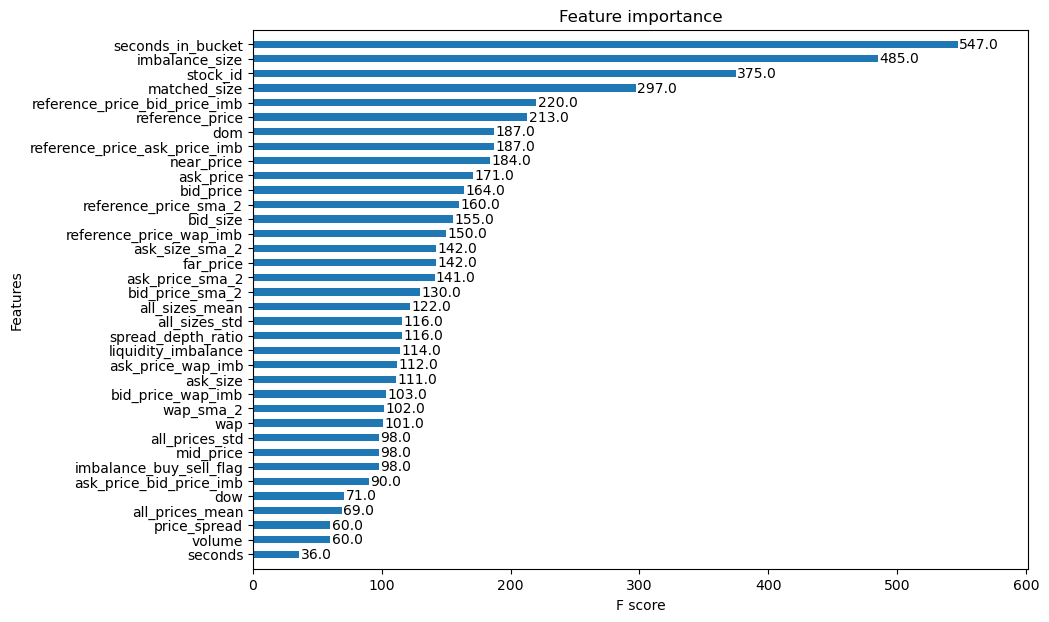

In [38]:
# Plot feature importance
plt.figure(1, figsize=(10, 7))
ax = plt.subplot(111)
plot_importance(xgb, ax, height=0.5, grid=False)
plt.show()

In [164]:
FEATURE_SELECTION = False

In [165]:
if FEATURE_SELECTION:
    # make predictions for validation data and evaluate
    predictions = xgb.predict(X_valid)
    mae = mean_absolute_error(y_valid, predictions)
    print("Validation MAE: %.2f" % mae)

    # Fit model using each importance as a threshold
    thresholds = np.sort(np.unique(xgb.feature_importances_))

    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)

        # train model
        selection_model = XGBRegressor()
        selection_model.fit(select_X_train, y_train)

        # eval model
        select_X_test = selection.transform(X_valid)
        predictions = selection_model.predict(select_X_test)

        mae = mean_absolute_error(y_valid, predictions)
        print("Thresh=%.3f, n=%d, Validation MAE: %.2f" % (thresh, select_X_train.shape[1], mae))

In [189]:
### Determine features to select
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

# columns_to_drop = ["seconds", "price_spread", "volume", "all_prices_mean", "wap_sma_2", "all_prices_std"]
columns_to_drop = ["seconds"]

X_train.drop(columns=columns_to_drop, inplace=True)
X_valid.drop(columns=columns_to_drop, inplace=True)

In [39]:
# Train model after feature selection
xgb = XGBRegressor()
xgb.fit(
    X_train,
    y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
RUN_CV = False

In [41]:
models = {
    # 'lr': LinearRegression(),
    'lgb': lgb.LGBMRegressor(objective='regression_l1', n_estimators=500),
    'xgb': XGBRegressor(tree_method='hist', objective='reg:absoluteerror', n_estimators=250)
}

for name, model in models.items():
    print(f'Training {name} model')

    model.fit(
        X_train,
        y_train.values.ravel()
        # eval_set=Pool(X_valid, y_valid)
    )
    
    if RUN_CV:
        print("Initiating Cross Validation and Computing MAE...")
        # Perform cross-validation and calculate MAE
        scores = cross_val_score(model, X_train_pp, y_train_pp, scoring='neg_mean_absolute_error', cv=3)
        mae = -scores.mean()
        print(f'{name} model MAE (CV): {mae:.4f}')

    # Calculate MAE for Test Dataset
    mae = mean_absolute_error(y_valid, model.predict(X_valid))
    print(f'{name} validation MAE: {mae:.4f}', end="\n\n")
    # print(model.get_best_iteration())

Training lgb model
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7949
[LightGBM] [Info] Number of data points in the train set: 4190314, number of used features: 37
[LightGBM] [Info] Start training from score -0.069737
lgb validation MAE: 6.1460

Training xgb model


KeyboardInterrupt: 

In [63]:
preds = np.mean([model.predict(X_valid) for _, model in models.items()], 0)
preds = pd.Series(preds, index=y_valid.index)
preds

4190314    1.43223
4190315   -0.57730
4190316   -0.29919
4190317   -2.87679
4190318   -0.18782
            ...   
5237887   -1.68698
5237888   -1.49166
5237889    0.15519
5237890    1.88425
5237891   -1.36208
Length: 1047578, dtype: float64

In [64]:
def plot_prediction(true, preds, stock_id, stock_idxs):
    stock_true = true[stock_idxs]
    stock_pred = preds[stock_idxs]
    error = mean_absolute_error(stock_true, stock_pred)
    plt.plot(stock_pred, color='green', label="prediction")
    plt.plot(stock_true, color='orange', alpha=0.5, label="actual")
    plt.legend(loc="upper left")
    plt.title(f"Stock {stock_id} predictions | MAE: {error:.5f}");

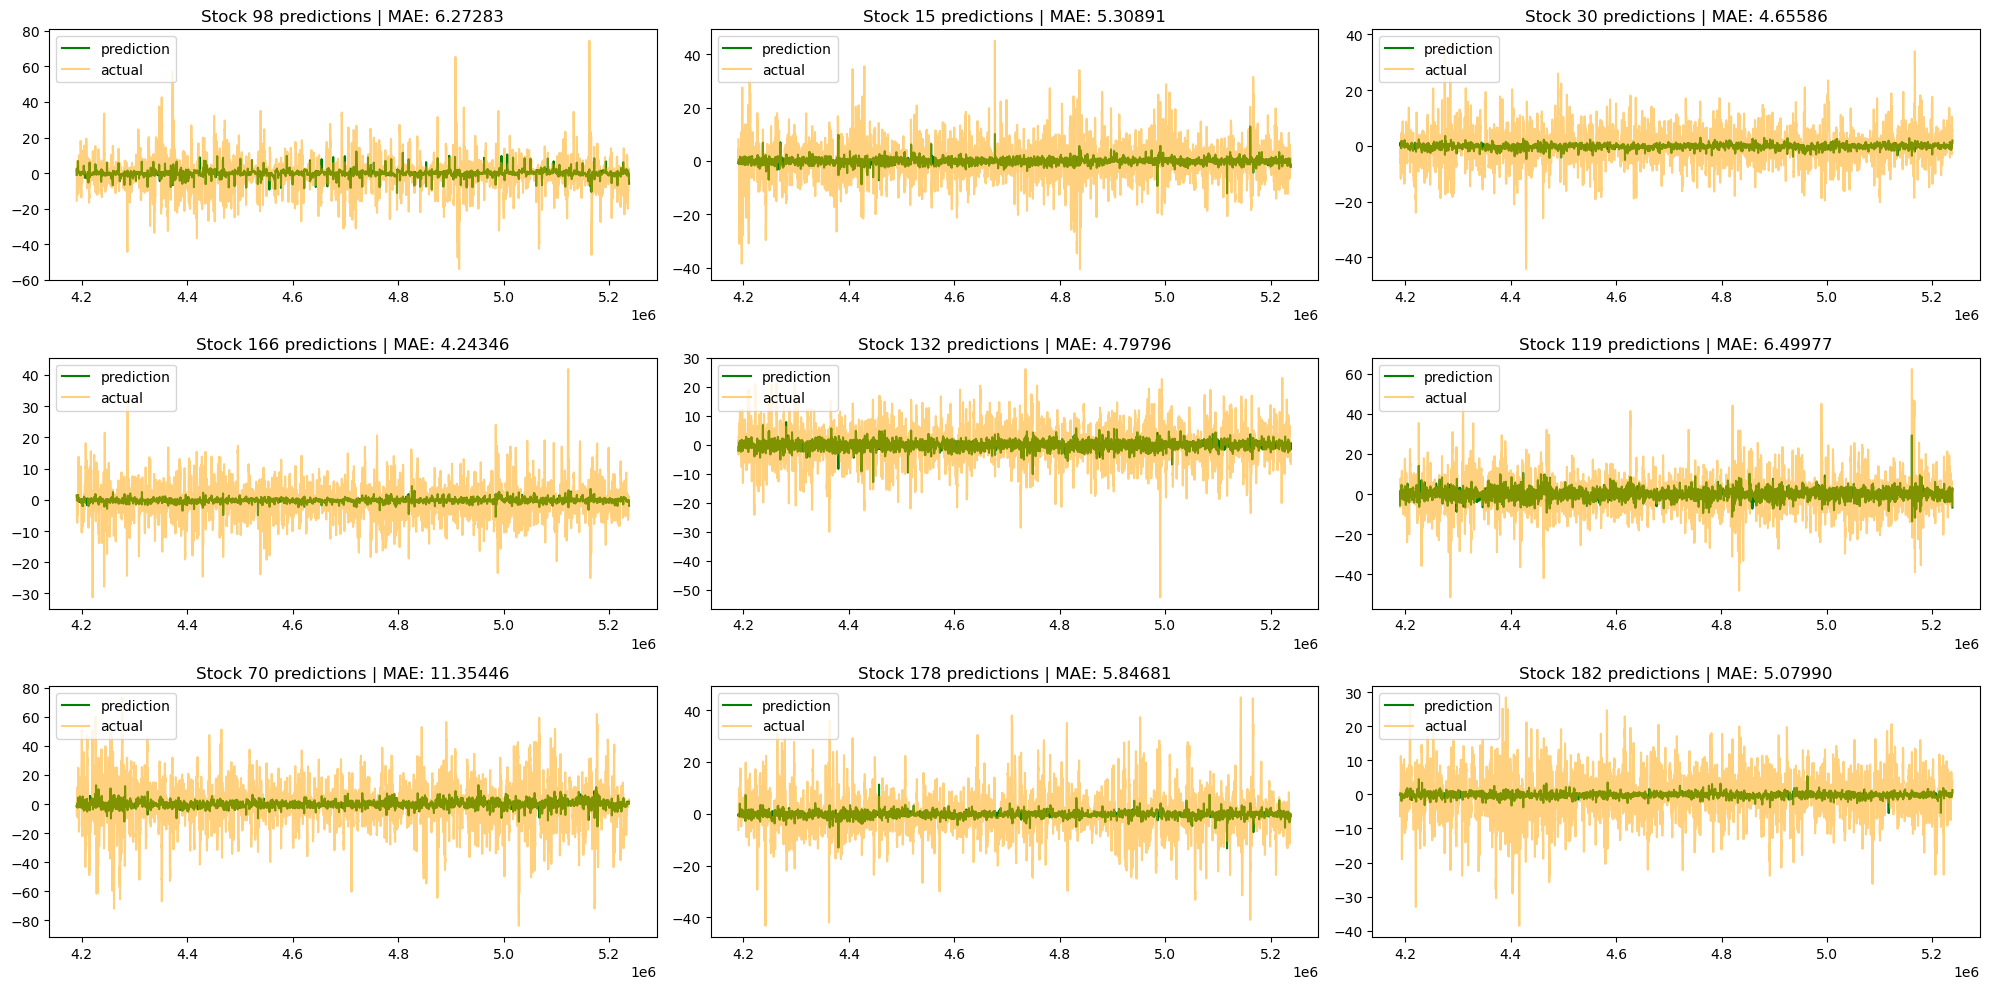

In [65]:
plt.figure(1, figsize=(20, 10))
for i, (id, stock_idxs) in enumerate(stocks.items()):
    plt.subplot(3, 3, i+1)
    idxs = stock_idxs['valid']
    plot_prediction(y_valid, preds, id, idxs)

plt.tight_layout()

# Make submission

In [17]:
# from sklearn.metrics import make_scorer,mean_absolute_error
# from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier, SGDOneClassSVM
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# if is_google_colab():

#     models = [
#         LinearRegression(),
#         # Ridge(),
#         # BayesianRidge(),
#     ]


#     for model in models:
#         model_pipeline = Pipeline(preprocess_steps + [('model', model)])

#         scores = cross_val_score(model_pipeline, tX.copy(), tY.copy(), cv=5, scoring='neg_mean_absolute_error')

#         print(f'model={model} | score={np.mean(scores):.3f}{chr(177)} {np.std(scores):.3f}\n')

In [18]:
# Train enseamble of models

models = {
        'lr': LinearRegression(),
        'lgb': lgb.LGBMRegressor(objective='regression_l1', n_estimators=250),
#         'xgb': xgb.XGBRegressor(tree_method='hist', objective='reg:absoluteerror', n_estimators=250)
}
for name, model in models.items():
    print(f'Training {name} model')

    model.fit(
        X_transformed,
        y_train.values.ravel())

Training lr model
Training lgb model
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.284750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9386
[LightGBM] [Info] Number of data points in the train set: 4242691, number of used features: 45
[LightGBM] [Info] Start training from score -0.060201


In [20]:
X_test = pipeline.transform(X_test)
X_test

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,dow,dom,seconds,minute,global_median_size,global_std_size,global_ptp_size,global_median_price,global_std_price,global_ptp_price
3893515,135,420,0.00e+00,0,1.00,2.45e+06,1.00,1.0,1.00,126571.45,...,3,18,0,7,153867.11,289683.97,4.01e+06,2.0,6.73e-03,0.04
2475662,27,300,7.59e+04,1,0.99,2.21e+07,1.00,1.0,0.99,1875.80,...,4,9,0,5,25474.19,75123.34,7.58e+05,2.0,4.78e-03,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005714,73,320,5.55e+05,1,1.00,1.03e+07,1.02,1.0,1.00,107297.50,...,1,6,20,5,129407.23,174408.62,2.02e+06,2.0,3.67e-03,0.02
4246375,195,460,2.20e+06,-1,1.00,3.96e+07,1.00,1.0,1.00,20086.69,...,0,10,40,7,51941.55,98218.03,2.76e+06,2.0,3.05e-03,0.01


In [22]:
model.predict(X_test)

array([-0.18,  0.78, ..., -0.15, -1.02])

In [27]:
# if not is_google_colab():
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

Exception: You can only call `make_env()` once.

In [28]:
from sklearn.metrics import mean_absolute_error
import pandas as pd

if is_google_colab():

    # Lists to store true and predicted targets
    true_targets = []
    predicted_targets = []

    for (test, revealed_targets, sample_prediction) in iter_test:
        # Predict target values
        test_processed = pipeline.transform(test)
        predictions = np.mean([model.predict(test_processed) for _, model in models.items()], 0)

        # Only take as many predictions and true targets as the minimum of the two
        min_len = min(len(predictions), len(revealed_targets))

        # Trim down the predictions list so that it is the same size as the revealed targets
        current_predictions = predictions[:min_len]
        current_true_targets = revealed_targets['revealed_target'].values[:min_len]

        # Extend the lists of true targets and predictions with the ones from the current batch
        true_targets.extend(current_true_targets)
        predicted_targets.extend(current_predictions)

        # Make the actual prediction and add to sample_prediction df
        sample_prediction['target'] = predictions

        # Submit the predictions for this chunk of test data
        env.predict(sample_prediction)

    # Convert lists to dataframes
    df_true = pd.DataFrame(true_targets, columns=['true_target'])
    df_pred = pd.DataFrame(predicted_targets, columns=['predicted_target'])

    # Calculate and print the MAE
    mae = mean_absolute_error(df_true.fillna(0), df_pred)
    print("Mean Absolute Error:", mae)
    # 5.261823197997517

NameError: name 'is_google_colab' is not defined

In [23]:
if not is_google_colab():
  counter = 0
  for (test, revealed_targets, sample_prediction) in iter_test:
      test_processed = pipeline.transform(test).values
      sample_prediction['target'] = np.mean([model.predict(test_processed) for _, model in models.items()], 0)
      env.predict(sample_prediction)
      counter += 1

In [24]:
tmr.ShowTime()    # measure Colab's runtime.

Runtime is 396 sec > 300 sec limit!!!
